In [1]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle


In [3]:
# Load Dataset

file_path = "/Users/Sebastiano/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,0,38,1,Mood abnormalities (depressive),0.67586,42.3566,438.3091,35.4223,438.2523,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,0,41,0,Na,0.70729,105.5166,472.6302,37.2214,466.0998,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,job1625735,0,58,2,Na,0.80425,32.0757,444.9024,32.3276,444.4705,...,2.5364,0.022803,19.3760,2.8289,0.025432,2.4842,0.022334,3.1091,0.027951,-22.3438
3,Paziente 3,0,32,0,Na,0.65236,49.4839,407.0018,33.7657,406.9770,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
4,job1625738,0,42,2,Na,0.66906,32.9605,354.9196,31.1643,339.6141,...,2.7589,0.026419,-1.7345,1.9995,0.019147,1.8184,0.017413,2.1486,0.020574,-16.6438


In [4]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [5]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 
# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [6]:
# Define your features and target variable
X = df.drop(['NP-SLE'], axis=1)  
y = df['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Applicable for 'poly' kernel
}

# Create the SVM classifier
svm_classifier = SVC()

# Initialize StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(svm_classifier, param_grid, cv=stratified_kfold)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVM classifier with the best hyperparameters
best_svm_classifier = grid_search.best_estimator_

# Train the best SVM classifier on the training data
best_svm_classifier.fit(X_train, y_train)

# Perform k-fold cross-validation and calculate the average accuracy
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=stratified_kfold)
average_cross_val_accuracy = cross_val_scores.mean()

# Predict on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Average Cross-Validation Accuracy:", average_cross_val_accuracy)
print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", report)


Best Hyperparameters: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
Average Cross-Validation Accuracy: 0.7607142857142858
Accuracy on Test Set: 0.8
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         6

    accuracy                           0.80        10
   macro avg       0.67      0.67      0.67        10
weighted avg       0.80      0.80      0.80        10



In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensions with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit the best SVM classifier on the reduced training data
best_svm_classifier.fit(X_train_pca, y_train)

# Predict on the reduced test set
y_pred_pca = best_svm_classifier.predict(X_test_pca)

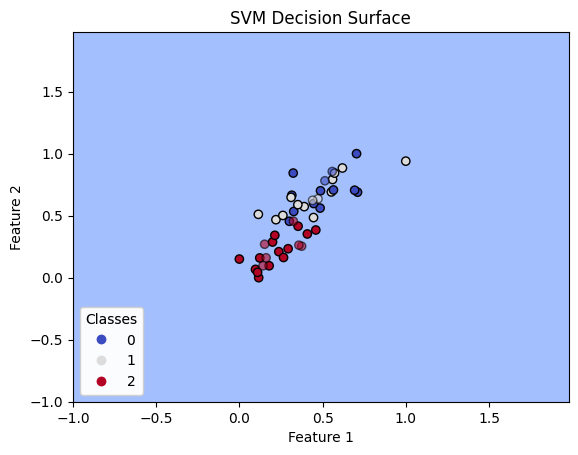

In [29]:
# Create a mesh to plot decision boundaries
h = .02  # Step size in the mesh
# Convert DataFrame to numpy array if 'X' is a DataFrame
X_np = X.values if isinstance(X, pd.DataFrame) else X

# Now you can use numpy-style indexing
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision boundaries
Z = best_svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Correct way to index a pandas DataFrame if X_train and X_test are DataFrames
scatter = plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.6)

# Create a legend for the classes
class_names = ['SLE', 'NPSLE', 'HC']
legend1 = plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
plt.gca().add_artist(legend1)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Surface')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

## 2-Classes

In [9]:
df_1 = df[df['NP-SLE'] != 0]
df_1.head()

,NP-SLE,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,Normal Appearing White Matter volume %,Abnormal Appearing White Matter volume cm3,Abnormal Appearing White Matter volume %,Grey Matter (GM) volume cm3,Grey Matter (GM) volume %,Subcortical Grey Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,1,0.389700,0.572857,0.427355,0.674365,0.000638,0.000554,0.513206,0.694244,0.574501,...,0.390653,0.406034,0.619618,0.567981,0.587819,0.546409,0.566108,0.580712,0.585133,0.247933
2,2,0.408502,0.352584,0.444218,0.503584,0.006234,0.005230,0.886409,0.925564,0.831869,...,0.475174,0.464917,0.633060,0.698939,0.687525,0.616384,0.605476,0.744831,0.714555,0.081213
4,2,0.151899,0.269784,0.159860,0.368124,0.228131,0.234308,0.340811,0.656686,0.076357,...,0.543784,0.587921,0.385616,0.414154,0.449706,0.372717,0.406984,0.437007,0.460700,0.177105
5,1,0.351496,0.588780,0.391064,0.686664,0.000417,0.000368,0.431840,0.674386,0.434694,...,0.628644,0.662656,0.328752,0.470672,0.497497,0.548861,0.579459,0.395569,0.408085,0.675549
7,2,0.109623,0.043226,0.000000,0.000000,0.886395,0.853131,0.459920,0.662139,0.330739,...,0.940980,0.979216,0.394055,0.796180,0.828627,0.673586,0.702645,0.860750,0.871885,0.000000


In [10]:
# Define your features and target variable
X = df_1.drop(['NP-SLE'], axis=1)  
y = df_1['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Applicable for 'poly' kernel
}

# Create the SVM classifier
svm_classifier = SVC()

# Initialize StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(svm_classifier, param_grid, cv=stratified_kfold)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVM classifier with the best hyperparameters
best_svm_classifier = grid_search.best_estimator_

# Train the best SVM classifier on the training data
best_svm_classifier.fit(X_train, y_train)

# Perform k-fold cross-validation and calculate the average accuracy
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=stratified_kfold)
average_cross_val_accuracy = cross_val_scores.mean()

# Predict on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Average Cross-Validation Accuracy:", average_cross_val_accuracy)
print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", report)


Best Hyperparameters: {'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
Average Cross-Validation Accuracy: 1.0
Accuracy on Test Set: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [13]:
df_2 = df[df['NP-SLE'] != 2]
df_2.head()

,NP-SLE,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,Normal Appearing White Matter volume %,Abnormal Appearing White Matter volume cm3,Abnormal Appearing White Matter volume %,Grey Matter (GM) volume cm3,Grey Matter (GM) volume %,Subcortical Grey Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,1,0.389700,0.572857,0.427355,0.674365,0.000638,0.000554,0.513206,0.694244,0.574501,...,0.390653,0.406034,0.619618,0.567981,0.587819,0.546409,0.566108,0.580712,0.585133,0.247933
1,0,0.487573,0.700912,0.502874,0.744909,0.097217,0.089514,0.583719,0.726881,0.289283,...,0.265799,0.272688,0.192077,0.195535,0.201406,0.180397,0.186226,0.207253,0.207705,0.285662
3,0,0.300421,0.454945,0.342540,0.583867,0.000161,0.000112,0.494503,0.744062,0.567590,...,0.501446,0.527201,0.486309,0.520974,0.546726,0.616311,0.646094,0.426528,0.436887,0.726340
5,1,0.351496,0.588780,0.391064,0.686664,0.000417,0.000368,0.431840,0.674386,0.434694,...,0.628644,0.662656,0.328752,0.470672,0.497497,0.548861,0.579459,0.395569,0.408085,0.675549
6,0,0.704137,1.000000,0.724600,1.000000,0.010422,0.009144,0.801241,0.926145,0.628418,...,0.900339,0.901998,0.283434,0.618970,0.619717,0.643869,0.644642,0.588372,0.573983,0.417085


In [14]:
# Define your features and target variable
X = df_2.drop(['NP-SLE'], axis=1)  
y = df_2['NP-SLE']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Applicable for 'poly' kernel
}

# Create the SVM classifier
svm_classifier = SVC()

# Initialize StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(svm_classifier, param_grid, cv=stratified_kfold)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best SVM classifier with the best hyperparameters
best_svm_classifier = grid_search.best_estimator_

# Train the best SVM classifier on the training data
best_svm_classifier.fit(X_train, y_train)

# Perform k-fold cross-validation and calculate the average accuracy
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=stratified_kfold)
average_cross_val_accuracy = cross_val_scores.mean()

# Predict on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Average Cross-Validation Accuracy:", average_cross_val_accuracy)
print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", report)


Best Hyperparameters: {'C': 0.1, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}
Average Cross-Validation Accuracy: 0.76
Accuracy on Test Set: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5

    accuracy                           0.67         6
   macro avg       0.40      0.40      0.40         6
weighted avg       0.67      0.67      0.67         6

